# GradCAM Jaccard

In [ ]:
import cv2
import numpy as np
import skimage.exposure
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.metrics import jaccard_score
%matplotlib inline

In [ ]:
img = cv2.imread("/content/drive/MyDrive/ImageNet50/im_0.png")

In [ ]:
annot_df = pd.read_csv("/content/via_project_7May2023_13h46m_csv.csv")

In [ ]:
annot_df.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,im_0.png,138537,"{""caption"":"""",""public_domain"":""no"",""image_url""...",1,0,"{""name"":""polyline"",""all_points_x"":[0,2,1,0,223...","{""name"":""not_defined"",""type"":""unknown"",""image_..."
1,im_1.png,64999,"{""caption"":"""",""public_domain"":""no"",""image_url""...",1,0,"{""name"":""polyline"",""all_points_x"":[20,105,117,...","{""name"":""not_defined"",""type"":""unknown"",""image_..."
2,im_2.png,126407,"{""caption"":"""",""public_domain"":""no"",""image_url""...",1,0,"{""name"":""polyline"",""all_points_x"":[27,24,79,82...","{""name"":""not_defined"",""type"":""unknown"",""image_..."
3,im_3.png,82101,"{""caption"":"""",""public_domain"":""no"",""image_url""...",1,0,"{""name"":""polyline"",""all_points_x"":[129,127,113...","{""name"":""not_defined"",""type"":""unknown"",""image_..."
4,im_4.png,123193,"{""caption"":"""",""public_domain"":""no"",""image_url""...",1,0,"{""name"":""polyline"",""all_points_x"":[1,59,59,61,...","{""name"":""not_defined"",""type"":""unknown"",""image_..."


In [ ]:
path = "/content/drive/MyDrive/ImageNet50/gt_masks/"

for i, f in enumerate(annot_df["filename"]):

  x_coords = json.loads(annot_df["region_shape_attributes"][i])["all_points_x"]
  y_coords = json.loads(annot_df["region_shape_attributes"][i])["all_points_y"]
  area = np.array(list(zip(x_coords, y_coords)))
  filled = np.zeros_like(img)
  filled = cv2.fillPoly(filled, pts = [area], color =(255,255,255))
  print(f)
  cv2_imshow(filled)
  # cv2.imwrite(f"/content/drive/MyDrive/ImageNet50/gt_masks/{f}", filled)

In [ ]:
def binarize(img):
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if img[i][j] == 255:
        img[i][j] = 1
      
      else:
        img[i][j] = 0

  return img

In [ ]:
def get_jaccard(file_name : str):

  jacc_list = []
  drop_list = [34, 27, 5, 16, 9] # snow, big flower (whole img),oil rig, balcony/penthouse, sea shore/coast

  for i in range(50):

    gt_img = Image.open(f"/content/drive/MyDrive/ImageNet50/gt_masks/im_{i}.png").convert("L")
    pred_img = Image.open(f"/content/drive/MyDrive/ImageNet50/{file_name}/im_{i}.png").convert("L")

    gt_img = np.array(gt_img)
    pred_img = np.array(pred_img)

    gt_img = binarize(gt_img)
    pred_img = binarize(pred_img)

    jac = jaccard_score(gt_img, pred_img, average="micro")

    if i in drop_list:
      continue
    
    else:
      jacc_list.append(jac)
    
  return jacc_list


In [ ]:
vgg_jac = get_jaccard("vgg_masks")
res_jac = get_jaccard("res_masks")
dense_jac = get_jaccard("dense_masks")

In [ ]:
print(np.mean(vgg_jac), np.mean(res_jac), np.mean(dense_jac))

0.12284669259120513 0.31789825257960913 0.3875065163172694


# Printing out few masks

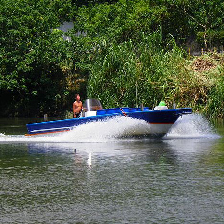

In [ ]:
im_pres = cv2.imread("/content/drive/MyDrive/ImageNet50/im_2.png")
cv2_imshow(im_pres)

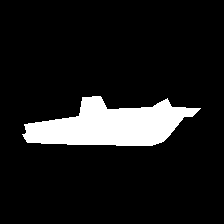

In [ ]:
im_mask = cv2.imread("/content/drive/MyDrive/ImageNet50/gt_masks/im_2.png", 0)
cv2_imshow(im_mask)

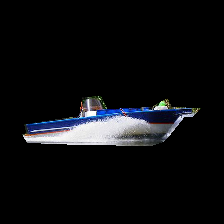

In [ ]:
im_mask = binarize(im_mask)
res = cv2.bitwise_and(im_pres, im_pres, mask = im_mask)
cv2_imshow(res)

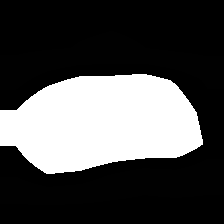

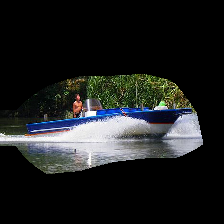

In [ ]:
im_mask = cv2.imread("/content/drive/MyDrive/ImageNet50/dense_masks/im_2.png", 0)
cv2_imshow(im_mask)
im_mask = binarize(im_mask)
res = cv2.bitwise_and(im_pres, im_pres, mask = im_mask)
cv2_imshow(res)

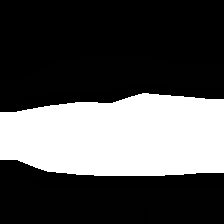

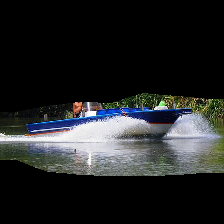

In [ ]:
im_mask = cv2.imread("/content/drive/MyDrive/ImageNet50/res_masks/im_2.png", 0)
cv2_imshow(im_mask)
im_mask = binarize(im_mask)
res = cv2.bitwise_and(im_pres, im_pres, mask = im_mask)
cv2_imshow(res)

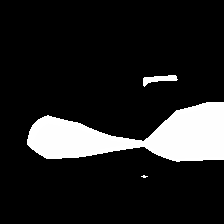

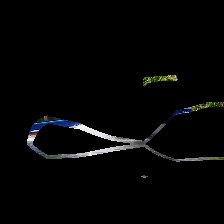

In [ ]:
im_mask = cv2.imread("/content/drive/MyDrive/ImageNet50/vgg_masks/im_2.png", 0)
cv2_imshow(im_mask)
im_mask = binarize(im_mask)
res = cv2.bitwise_and(im_pres, im_pres, mask = im_mask)
cv2_imshow(res)

# SHAP: Make occluded images and masks

In [ ]:
path = "/content/drive/MyDrive/ImageNet50/shap_vgg16_cropped/"


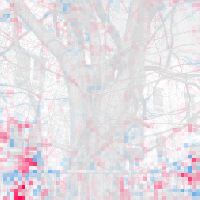

In [ ]:
img= Image.open(path + f"cropped_shap_vgg16_0.png").convert("RGB")
img

In [ ]:
img= Image.open(path + f"cropped_shap_vgg16_0.png").convert("L")

In [ ]:
def thresholding(img, binary_mask = False, thresh_val=210):
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if img[i][j] < thresh_val:
        if binary_mask:
          img[i][j] = 0
        else:
          continue
      else:
        img[i][j] = 255

  return img

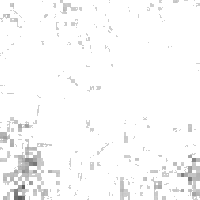

In [ ]:
thresh_img = thresholding(np.array(img))
Image.fromarray(thresh_img)

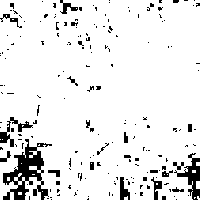

In [ ]:
thresh_img = thresholding(np.array(img), binary_mask=True)
Image.fromarray(thresh_img)

In [ ]:
def get_thresh_bin(model_name:str, displays=True, thresh_val=210):

  occl = []
  bin_ims = []

  for i in range(50):
    path = f"/content/drive/MyDrive/ImageNet50/shap_{model_name}_cropped/"

    if displays:
      print(i)

    img= Image.open(path + f"cropped_shap_{model_name}_{i}.png").convert("RGB")
    if displays:
      display(img)
    
    img= Image.open(path + f"cropped_shap_{model_name}_{i}.png").convert("L")  
    if displays:
      display(img)
    
    thresh_img = thresholding(np.array(img), thresh_val=thresh_val)
    if displays:
      display(Image.fromarray(thresh_img))

    occl.append(thresh_img)
    
    bin_img = thresholding(np.array(img), binary_mask=True, thresh_val=thresh_val)
    if displays:
      display(Image.fromarray(bin_img))
    bin_ims.append(bin_img)
  
  return occl, bin_ims


In [ ]:
vgg_occl, vgg_bin_ims = get_thresh_bin("vgg16")

In [ ]:
res_occl, res_bin_ims = get_thresh_bin("resnet50")

In [ ]:
dense_occl, dense_bin_ims = get_thresh_bin("densenet121")

In [ ]:
def multiply_img_mask(masks, invert=False, displays=True):

  # get list of images
  path = "/content/drive/MyDrive/ImageNet50/"

  perturbed_imgs = []

  for i in range(50):
    im_path = path + f"im_{i}.png"
    im = Image.open(im_path).convert("RGB")
    im = np.array(im)

    masks[i] = cv2.resize(masks[i], (224,224))
    masks[i] = np.array(Image.fromarray(masks[i].astype(np.uint8)).convert("RGB"))


    if invert is True:
      masks[i] = 255 - masks[i]
    
    mult_img = np.multiply(im/255, masks[i]/255)

    mult_img_pil = Image.fromarray((mult_img*255).astype(np.uint8))

    perturbed_imgs.append((mult_img*255).astype(np.uint8))

    # mult_img_pil.save(path + file_name + f"/im_{i}.png")
    if displays:
      display(mult_img_pil)
  
  return perturbed_imgs


In [ ]:
p_vgg = multiply_img_mask(vgg_bin_ims)
p_vgg_inv = multiply_img_mask(vgg_bin_ims, invert=True, displays=False)

In [ ]:
p_res = multiply_img_mask(res_bin_ims)
p_res_inv = multiply_img_mask(res_bin_ims, invert=True, displays=False)

In [ ]:
p_dense = multiply_img_mask(dense_bin_ims)
p_dense_inv = multiply_img_mask(dense_bin_ims, invert=True, displays=False)

# SHAP: Calculate Metrics

In [ ]:
import os
import glob
import torch
import torch.nn as nn
from torch.utils import data
import numpy as np
import torchvision
from torchvision.transforms.transforms import ToPILImage
from torchvision import transforms, datasets
import cv2 
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

In [ ]:
model_vgg = torchvision.models.vgg16(weights="IMAGENET1K_V1") 
model_resnet = torchvision.models.resnet50(weights="IMAGENET1K_V1") 
model_densenet = torchvision.models.densenet121(weights="IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 145MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 122MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 79.2MB/s]


In [ ]:
path = "/content/drive/MyDrive/ImageNet50/images"
im_paths = os.listdir(path)
from natsort import natsorted 
im_paths = natsorted(im_paths)

In [ ]:
import pandas as pd

label_df = pd.read_excel("/content/ImageNet1k.xlsx")
label_df.head()

,Class ID,Class Name
0,0,"tench, Tinca tinca"
1,1,"goldfish, Carassius auratus"
2,2,"great white shark, white shark, man-eater, man..."
3,3,"tiger shark, Galeocerdo cuvieri"
4,4,"hammerhead, hammerhead shark"


In [ ]:
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


In [ ]:
def get_predictions(model, im_paths):

  predictions = []
  labels = []
  confidence = []

  for i,d in enumerate(im_paths):
    # path
    path = "/content/drive/MyDrive/ImageNet50/images/" + d + "/"

    # create data loader
    dataset = datasets.ImageFolder(root=path, transform=transform)
    dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)
    
    model.eval()

    img, _ = next(iter(dataloader))
    pred = model(img)

    top_1 = torch.argmax(pred).item()
    label = label_df[label_df["Class ID"] == top_1].to_numpy()[0][1]

    for f in glob.glob(path + "*.png"):
      im_name = f

      #print(top_1, label)
      predictions.append(top_1)
      labels.append(label)
      confidence.append(torch.max(pred, dim=1).values.detach().item())

      #im = cv2.imread(im_name)
      #cv2_imshow(im)

  return predictions, labels, confidence

In [ ]:
vgg_pred, vgg_labels, vgg_confidence = get_predictions(model_vgg, im_paths)

In [ ]:
resnet_pred, resnet_labels, res_confidence = get_predictions(model_resnet, im_paths)

In [ ]:
densenet_pred, densenet_labels, dense_confidence = get_predictions(model_densenet, im_paths)

In [ ]:
def get_new_confidence(model, occl, predictions, displays=True):

  path = "/content/drive/MyDrive/ImageNet50/"
  new_confs = []

  ctr_incorrect = 0

  for i in range(50):
    # im_path = path + file_name + f"/im_{i}.png"

    im = Image.fromarray(np.array(occl[i]).astype(np.uint8))

    if displays:
     display(im)
    im = transform(im).unsqueeze(0)

    model.eval()

    with torch.no_grad():
      pred = model(im)
      top_1 = torch.argmax(pred).item()
      conf = torch.max(pred, dim=1).values.item()

      if top_1 != predictions[i]: # checking if confidence drops even if the label is incorrect
        label = label_df[label_df["Class ID"] == top_1].to_numpy()[0][1]
        label2 = label_df[label_df["Class ID"] == predictions[i]].to_numpy()[0][1]
        conf = pred[0, predictions[i]]
        # print(label, label2)
        ctr_incorrect += 1
      
      new_confs.append(conf)
  
  print(ctr_incorrect)

  return new_confs

In [ ]:
vgg_p_conf = get_new_confidence(model_vgg, p_vgg, vgg_pred, displays=False)
vgg_p_conf_inv = get_new_confidence(model_vgg, p_vgg_inv, vgg_pred,displays=False)

In [ ]:
res_p_conf = get_new_confidence(model_resnet, p_res, resnet_pred, displays=False)
res_p_conf_inv = get_new_confidence(model_resnet, p_res_inv, resnet_pred,displays=False)

In [ ]:
dense_p_conf = get_new_confidence(model_densenet, p_dense, densenet_pred, displays=False)
dense_p_conf_inv = get_new_confidence(model_densenet, p_dense_inv, densenet_pred,displays=False)

In [ ]:
# ref: Grad-CAM++ https://arxiv.org/pdf/1710.11063.pdf

def get_gradcam_metrics(conf_og, conf_occ):

  drop_in_confidence = []
  conf_og = np.array(conf_og)
  conf_occ = np.array(conf_occ)

  sum = 0

  for i in range(len(conf_og)):
    # print(conf_og[i])
    Max = max(0, conf_og[i] - conf_occ[i])
    avg = Max / conf_og[i]
    #print(avg)
    drop_in_confidence.append(avg)
    # sum += avg

  avg_increase = 0

  for i, x in enumerate(zip(conf_og, conf_occ)): # avg increase

    if x[0] < x[1]:
      # print(i)
      avg_increase += 1
    
  # print(avg_increase/50)

  return np.mean(drop_in_confidence), avg_increase/50

In [ ]:
vgg_metrics = get_gradcam_metrics(vgg_confidence, vgg_p_conf)

print("Mean drop in confidence: ", vgg_metrics[0], " Mean increase in confidence: ", vgg_metrics[1])

Mean drop in confidence:  0.660412770799518  Mean increase in confidence:  0.04


In [ ]:
vgg_metrics_inv = get_gradcam_metrics(vgg_confidence, vgg_p_conf_inv)

# want a drop in confidence

print("Mean drop in confidence: ", vgg_metrics_inv[0], " Mean increase in confidence: ", vgg_metrics_inv[1])

Mean drop in confidence:  0.8661523668570689  Mean increase in confidence:  0.0


In [ ]:
res_metrics = get_gradcam_metrics(res_confidence, res_p_conf)

print("Mean drop in confidence: ", res_metrics[0], " Mean increase in confidence: ", res_metrics[1])

Mean drop in confidence:  0.646579542014194  Mean increase in confidence:  0.04


In [ ]:
res_metrics_inv = get_gradcam_metrics(res_confidence, res_p_conf_inv)

print("Mean drop in confidence: ", res_metrics_inv[0], " Mean increase in confidence: ", res_metrics_inv[1])

Mean drop in confidence:  0.854675987511023  Mean increase in confidence:  0.02


In [ ]:
dense_metrics = get_gradcam_metrics(dense_confidence, dense_p_conf)

print("Mean drop in confidence: ", dense_metrics[0], " Mean increase in confidence: ", dense_metrics[1])

Mean drop in confidence:  0.6673262306193917  Mean increase in confidence:  0.02


In [ ]:
dense_metrics_inv = get_gradcam_metrics(dense_confidence, dense_p_conf_inv)

print("Mean drop in confidence: ", dense_metrics_inv[0], " Mean increase in confidence: ", dense_metrics_inv[1])

Mean drop in confidence:  0.7597814637119232  Mean increase in confidence:  0.0


In [ ]:
!pip install grad-cam

In [ ]:
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst, ROADLeastRelevantFirst
from pytorch_grad_cam.utils.image import deprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from typing import List, Callable

In [ ]:
def get_ROAD_score(model, occl, preds, percentile=40, percentile2=80, display_ims=True):
  # percentile = 40
  cam_metric = ROADMostRelevantFirst(percentile=percentile)
  cam_metric2 = ROADLeastRelevantFirst(percentile=percentile2)

  to_pytorch_tensor = transforms.Compose([transforms.ToTensor()])

  score_list1 = []
  score_list2 = []

  for i in range(50):
    im_path = f"/content/drive/MyDrive/ImageNet50/im_{i}.png"
    tst_im = Image.open(im_path).convert("RGB")

    input_tensor = to_pytorch_tensor(tst_im)
    input_pil = transforms.ToPILImage()(input_tensor).convert("RGB")
 
    grayscale_cams =  np.array(Image.fromarray(occl[i]).convert("L"))
    grayscale_cams_pil = Image.fromarray(grayscale_cams).convert("RGB")

    grayscale_cams = np.expand_dims(grayscale_cams, axis=0)

    targets = [ClassifierOutputSoftmaxTarget(preds[i])]

    scores, visualizations = cam_metric(input_tensor.unsqueeze(0), grayscale_cams/255, targets, model, return_visualization=True)
    score = scores[0]

    scores2, visualizations2 = cam_metric2(input_tensor.unsqueeze(0), grayscale_cams/255, targets, model, return_visualization=True)
    score2 = scores2[0]

    vis_pil = transforms.ToPILImage()(visualizations.squeeze(0)).convert("RGB")
    vis_pil2 = transforms.ToPILImage()(visualizations2.squeeze(0)).convert("RGB")

    if display_ims:
      print(f"The confidence increase when removing {100-percentile}% of the image: {score}")

      display(Image.fromarray(np.hstack((input_pil, grayscale_cams_pil, vis_pil, vis_pil2))))

    score_list1.append(score)
    score_list2.append(score2)

  return score_list1, score_list2

In [ ]:
vgg_ROAD_scores = get_ROAD_score(model_vgg, 255 - np.array(vgg_bin_ims), vgg_pred, percentile=50)

In [ ]:
## Clearly, the interpolation becomes messy if the percentile is too low.
## Calculating the scores for a percentile of 80

vgg_ROAD_scores = get_ROAD_score(model_vgg, 255 - np.array(vgg_occl), vgg_pred, percentile=80, display_ims=False)
res_ROAD_scores = get_ROAD_score(model_resnet, np.array(res_occl), resnet_pred, percentile=80, display_ims=False)
dense_ROAD_scores = get_ROAD_score(model_densenet, dense_occl, densenet_pred, percentile=80, display_ims=False)


In [ ]:
vgg_avg_mrf = np.mean(vgg_ROAD_scores[0])
vgg_avg_lrf = np.mean(vgg_ROAD_scores[1])
vgg_avg_combined = (vgg_avg_mrf - vgg_avg_lrf)/2

print("Confidence increase when occluding image except areas detected: ", vgg_avg_mrf, "(higher the better)", 
      "\nConfidence increase when occluding image except areas NOT detected: ", vgg_avg_lrf, "(lower the better)", 
      "\nCombined: ", vgg_avg_combined, "(higher the better)")

Confidence increase when occluding image except areas detected:  -0.20548002 (higher the better) 
Confidence increase when occluding image except areas NOT detected:  -0.19837876 (lower the better) 
Combined:  -0.0035506337881088257 (higher the better)


In [ ]:
res_avg_mrf = np.mean(res_ROAD_scores[0])
res_avg_lrf = np.mean(res_ROAD_scores[1])
res_avg_combined = (res_avg_mrf - res_avg_lrf)/2

print("Confidence increase when occluding image except areas detected: ", res_avg_mrf, "(higher the better)", 
      "\nConfidence increase when occluding image except areas NOT detected: ", res_avg_lrf, "(lower the better)", 
      "\nCombined: ", res_avg_combined, "(higher the better)")

Confidence increase when occluding image except areas detected:  -0.32392457 (higher the better) 
Confidence increase when occluding image except areas NOT detected:  -0.31118786 (lower the better) 
Combined:  -0.006368353962898254 (higher the better)


In [ ]:
dense_avg_mrf = np.mean(dense_ROAD_scores[0])
dense_avg_lrf = np.mean(dense_ROAD_scores[1])
dense_avg_combined = (dense_avg_mrf - dense_avg_lrf)/2

print("Confidence increase when occluding image except areas detected: ", dense_avg_mrf, "(higher the better)", 
      "\nConfidence increase when occluding image except areas NOT detected: ", dense_avg_lrf, "(lower the better)", 
      "\nCombined: ", dense_avg_combined, "(higher the better)")

Confidence increase when occluding image except areas detected:  -0.48257062 (higher the better) 
Confidence increase when occluding image except areas NOT detected:  -0.3540149 (lower the better) 
Combined:  -0.06427785754203796 (higher the better)


In [ ]:
def get_jaccard_shap(masks):

  jacc_list = []
  drop_list = [34, 27, 5, 16, 9] # snow, big flower (whole img),oil rig, balcony/penthouse, sea shore/coast

  for i in range(50):

    gt_img = Image.open(f"/content/drive/MyDrive/ImageNet50/gt_masks/im_{i}.png").convert("L")
    pred_img = Image.fromarray(masks[i]).convert("L")
    # display(gt_img)
    # display(pred_img)

    gt_img = np.array(gt_img)
    pred_img = np.array(pred_img)

    gt_img = binarize(gt_img)
    pred_img = binarize(pred_img)

    jac = jaccard_score(gt_img, pred_img, average="micro")

    if i in drop_list:
      continue
    
    else:
      jacc_list.append(jac)
    
  return jacc_list


In [ ]:
vgg_shap_jacc = get_jaccard_shap(vgg_bin_ims)
res_shap_jacc = get_jaccard_shap(res_bin_ims)
dense_shap_jacc = get_jaccard_shap(dense_bin_ims)

print(np.mean(vgg_shap_jacc), np.mean(res_shap_jacc), np.mean(dense_shap_jacc))

0.19478702822339475 0.26243746331725887 0.27654120387821085
